# week2

lab 1

일정 기간을 보고 다음 값을 바로 예측하기 위해, 시퀀셜 데이터를 윈도우 크기로 나누어 만들어주자

In [45]:
import tensorflow as tf

# 0 ~ 9 까지 생성
dataset = tf.data.Dataset.range(10)

# 시퀀셜 데이터에 대해 윈도우를 생성해준다. drop_remainder는 뒤쪽 나머지를 버림.
dataset = dataset.window(size=5, shift=1, drop_remainder=True)
for window_dataset in dataset:
  print([item.numpy() for item in window_dataset])


[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [46]:
# 각 데이터가 tf.data.Dataset 타입이어서 이를 길이 5의 벡터, tf.Tensor 타입으로 바꾸어 준 것.
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset1:
  print(window.numpy())

# 레이블을 분리해주고,
dataset = dataset1.map(lambda window: (window[:-1], window[-1]))

# 몇 개 뽑아서, shuffle해주자.
dataset = dataset.shuffle(buffer_size=10)

# 2개씩 일괄처리 하겠다..prefetch는 미리 대기 시켜두기 위함.
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())


[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]
x =  [[1 2 3 4]
 [0 1 2 3]]
y =  [5 4]
x =  [[2 3 4 5]
 [3 4 5 6]]
y =  [6 7]
x =  [[4 5 6 7]
 [5 6 7 8]]
y =  [8 9]


lab2

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

이전 시퀀셜에서 사용했던 그래프 만들기 위한 함수들

In [48]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def trend(time, slope=0):
    series = slope * time
    return series

def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    return noise

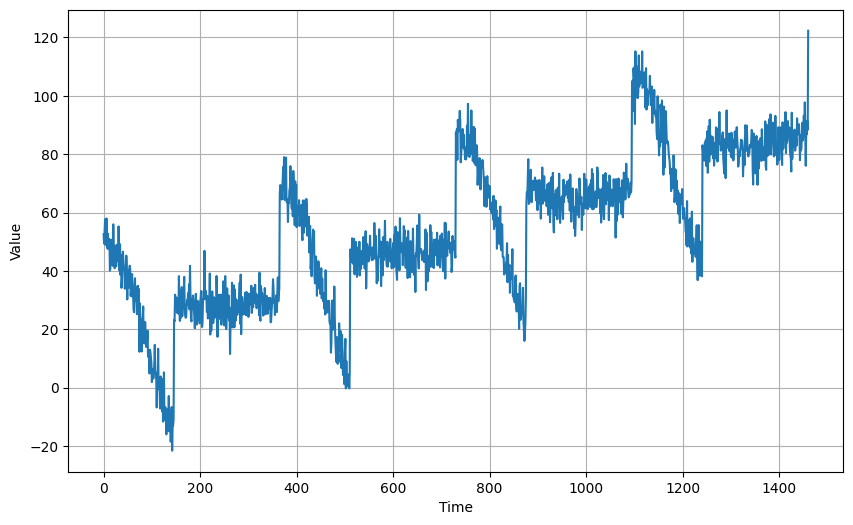

In [65]:
# 적절한 학습용 그래프 생성.
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)
plot_series(time, series)

In [66]:
# train valid 나누기
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [67]:
# 파라미터 설정.
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [68]:
# 시퀀셜 데이터를 입맛에 맞게 학습 데이터셋으로 튜닝.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # 텐서로 변환이 가능한 놈은 바꿔준다. 파이썬 리스트, 넘파이 리스트 둘 다 가능
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)    
    return dataset

In [69]:
# 생성해보자.
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 데이터 확인
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [71]:
# 레이어가 하나, 선형 회귀
# Sequential 안에 설정해 둬도 되지만 초기 웨이트 상태를 찍어보자.
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# 웨이트 확인
print("Layer weights: \n {} \n".format(l0.get_weights()))
# 각 20개 값에 곱해지는 가중치들과 bias하나로 총 21개 파라미터가 있다.

model.summary()

Layer weights: 
 [array([[ 0.0207355 ],
       [ 0.06709796],
       [-0.15642545],
       [-0.03399831],
       [-0.1656321 ],
       [-0.0702135 ],
       [-0.2325992 ],
       [-0.10662198],
       [-0.10537627],
       [ 0.04265916],
       [-0.5210234 ],
       [-0.45045802],
       [ 0.4641261 ],
       [-0.07101318],
       [-0.49443632],
       [ 0.43277913],
       [-0.1167253 ],
       [-0.36174774],
       [ 0.4259606 ],
       [-0.08142567]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 28ms/step - loss: 183.8154
Epoch 2/100
31/31 [==============================] - 0s 695us/step - loss: 102.9345
Epoch 3/100
31/31 [==============================] - 0s 699us/step - loss: 98.0800
Epoch 4/100
31/31 [==============================] - 0s 627us/step - loss: 95.7864
Epoch 5/100
31/31 [==============================] - 0s 589us/step - loss: 92.4628
Epoch 6/100
31/31 [==============================] - 0s 593us/step - loss: 89.7187
Epoch 7/100
31/31 [==============================] - 0s 663us/step - loss: 87.9350
Epoch 8/100
31/31 [==============================] - 0s 692us/step - loss: 86.2247
Epoch 9/100
31/31 [==============================] - 0s 656us/step - loss: 85.1531
Epoch 10/100
31/31 [==============================] - 0s 626us/step - loss: 82.6669
Epoch 11/100
31/31 [==============================] - 0s 619us/step - loss: 80.3869
Epoch 12/100
31/31 [==============================] - 0s 597us/step - loss: 79.2463


In [60]:
# 학습 이후 웨이트 확인
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.01195412],
       [-0.07336038],
       [ 0.10456852],
       [-0.05709741],
       [ 0.07971368],
       [-0.00947633],
       [-0.08143833],
       [-0.03429462],
       [ 0.10200308],
       [ 0.02410723],
       [-0.11507568],
       [ 0.0646182 ],
       [-0.00419175],
       [ 0.05759897],
       [-0.00676987],
       [-0.0023625 ],
       [ 0.01505099],
       [ 0.18711244],
       [ 0.28262657],
       [ 0.45716393]], dtype=float32), array([0.01110718], dtype=float32)]


In [74]:
# 예시를 봐주자.
print(f'shape of series[0:20]: {series[0:20].shape}')

# predict를 위해 차원 확장을 해주자.
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# 이렇게 해도 된다.
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# 예측해보면..
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 19ms/step
model prediction: [[-72.8783]]


In [62]:
# 예측 값을 담아둘 리스트.
forecast = []

# 위의 예측을 반복해주자.
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# validaiton 부분만 보면, 
forecast = forecast[split_time - window_size:]

# 길이를 보자.
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 16ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


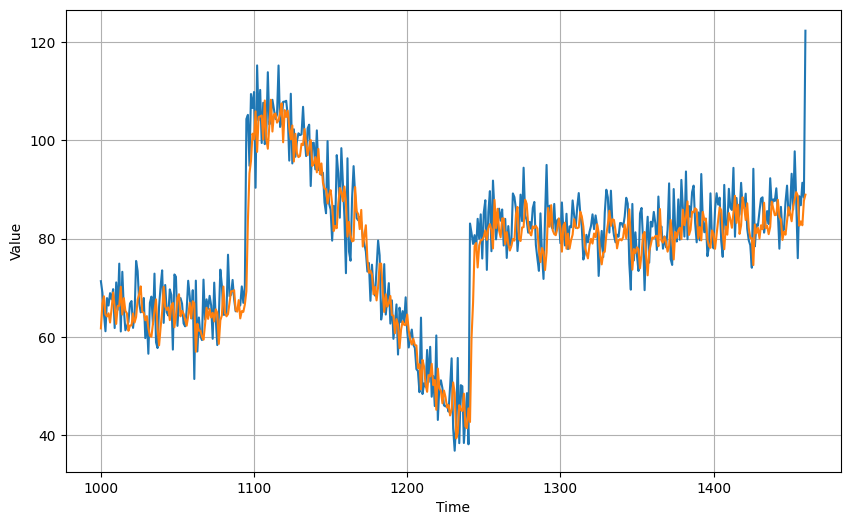

In [63]:
# forecast 리스트 내에 각 예측값이 2차원 넘파이 어레이로 저장되어 있다.
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# 스퀴즈 해주자.
results = np.array(forecast).squeeze()
plot_series(time_valid, (x_valid, results))

In [64]:
# 과연 MSE와 MAE는..
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.83631
5.106947


lab 3 (edit....)

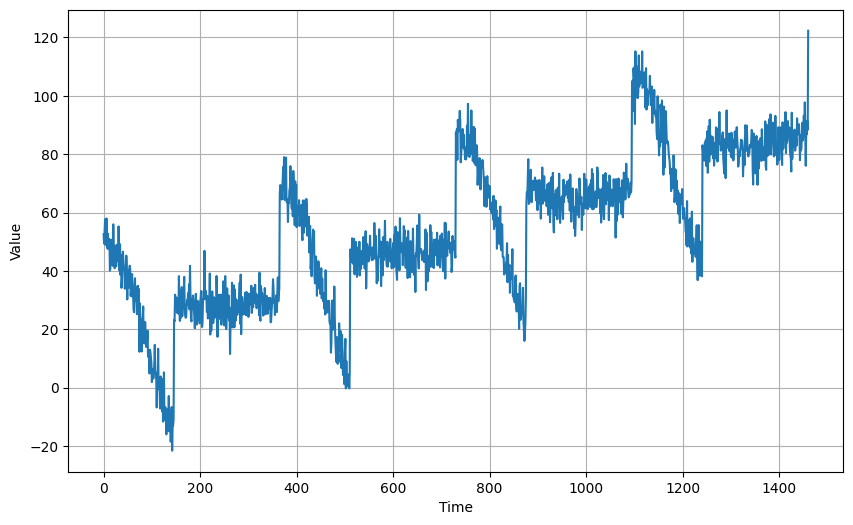

In [77]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [78]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [79]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [80]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [81]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [83]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 314.9566
Epoch 2/100
31/31 [==============================] - 0s 868us/step - loss: 97.8371
Epoch 3/100
31/31 [==============================] - 0s 734us/step - loss: 86.8022
Epoch 4/100
31/31 [==============================] - 0s 898us/step - loss: 80.0256
Epoch 5/100
31/31 [==============================] - 0s 867us/step - loss: 77.1148
Epoch 6/100
31/31 [==============================] - 0s 737us/step - loss: 72.3800
Epoch 7/100
31/31 [==============================] - 0s 711us/step - loss: 69.7348
Epoch 8/100
31/31 [==============================] - 0s 721us/step - loss: 67.3970
Epoch 9/100
31/31 [==============================] - 0s 751us/step - loss: 66.1945
Epoch 10/100
31/31 [==============================] - 0s 748us/step - loss: 64.2538
Epoch 11/100
31/31 [==============================] - 0s 735us/step - loss: 63.0926
Epoch 12/100
31/31 [==============================] - 0s 766us/step - loss: 61.9807
Ep

1/1 [==============================] - 0s 14ms/step


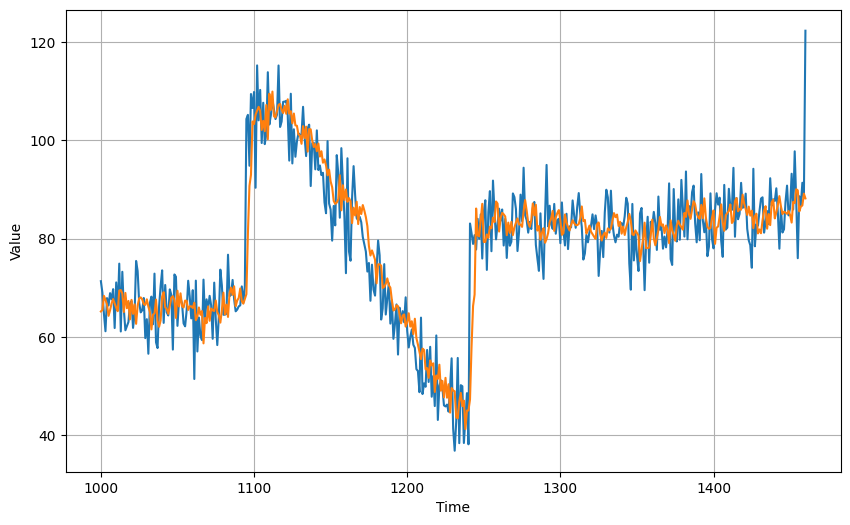

In [84]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [85]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

43.089798
4.893942


In [86]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [87]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [88]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

In [89]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 835.5654 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 885us/step - loss: 564.4324 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 767us/step - loss: 355.2404 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 792us/step - loss: 227.3942 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 759us/step - loss: 157.6111 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 800us/step - loss: 123.4132 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 744us/step - loss: 109.8242 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 779us/step - loss: 104.0797 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 744us/step - loss: 101.5037 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 851us/step - loss: 99.6632 - lr: 2.8

(1e-08, 0.001, 0.0, 300.0)

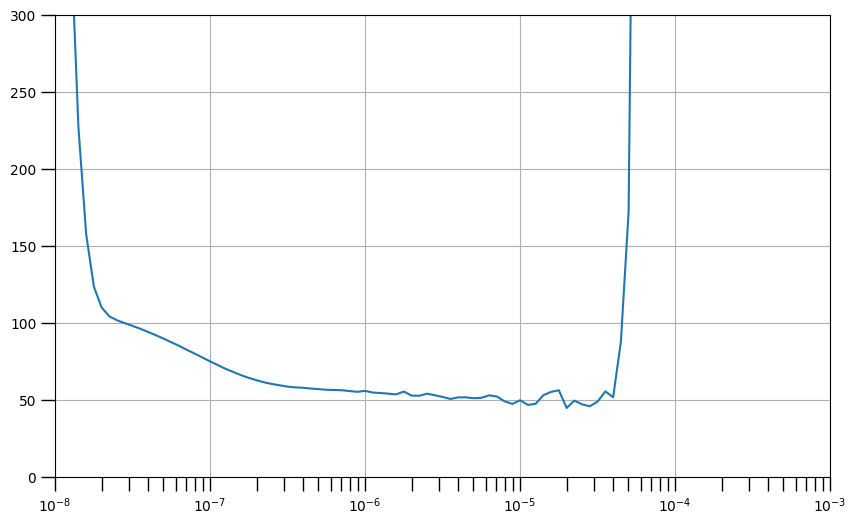

In [90]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [91]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [92]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

In [93]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 1596.9296
Epoch 2/100
31/31 [==============================] - 0s 771us/step - loss: 147.9074
Epoch 3/100
31/31 [==============================] - 0s 765us/step - loss: 67.2762
Epoch 4/100
31/31 [==============================] - 0s 766us/step - loss: 61.7560
Epoch 5/100
31/31 [==============================] - 0s 834us/step - loss: 58.0203
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 54.9333
Epoch 7/100
31/31 [==============================] - 0s 801us/step - loss: 53.2335
Epoch 8/100
31/31 [==============================] - 0s 833us/step - loss: 50.9849
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 49.4050
Epoch 10/100
31/31 [==============================] - 0s 935us/step - loss: 48.6623
Epoch 11/100
31/31 [==============================] - 0s 800us/step - loss: 47.9006
Epoch 12/100
31/31 [==============================] - 0s 766us/step - loss: 48.3414
Epoc

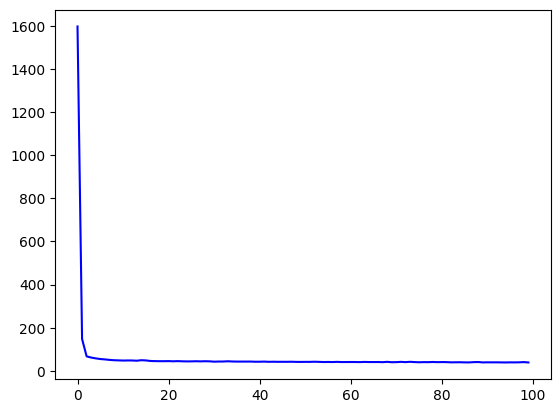

In [94]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

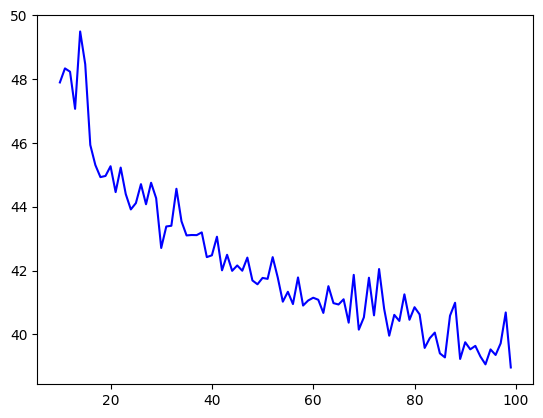

In [95]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 15ms/step


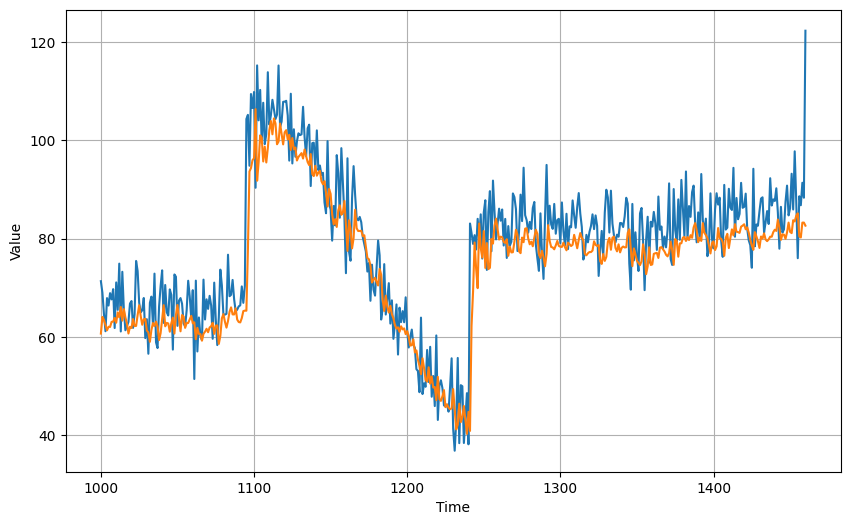

In [96]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [97]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

57.807384
5.649437
